# Control platform and wheel in gravity with partial state feedback

Do all imports:

In [1]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_platform_nonlinearsensors

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Jan 28 2022 20:18:15


Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [2]:
simulator = ae353_platform_nonlinearsensors.Simulator(
    display=True,
    roll=np.pi / 2,
    sensor_noise=0.1,
)

Given a choice of ground roll angle $\phi$, the equations of motion are

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

where

* $q_1$ is the platform angle
* $\dot{q}_1$ is the platform velocity
* $v_2$ is the wheel velocity
* $\tau$ is the torque applied *to* the platform *by* the wheel

and

$$
J_1 = J_p + m_wl^2
\qquad
\qquad
J_2 = J_w
$$

and parameter values are defined as follows:

In [3]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# gravity
g = 9.81

# composite parameters
J1 = Jp + mw * l**2
J2 = Jw

The equations of motion in this particular case ($\phi=\pi/2$) are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)
\end{aligned}
$$

Write equations of motion as

$$
\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{v}_2 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

and linearize them about a particular choice of equilibrium point.

In [4]:
# Choose equilibrium point
(q1e, v1e, v2e, taue) = (np.pi, 0., 0., 0.)

# Define variables
q1, v1, v2, tau = sym.symbols('q1, v1, v2, tau')

# Define right-hand side of ODEs
f = sym.Matrix([
    v1,
    (1 / J1) * (tau - mw * g * l * sym.sin(q1)),
    (1 / J2) * (- ((J1 + J2) / J1) * tau + (J2 / J1) * mw * g * l * sym.sin(q1))
])

# Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)

# Verify equilibrium point
f_num = sym.lambdify([q1, v1, v2, tau], f)
if not np.allclose(f_num(q1e, v1e, v2e, taue), 0.):
    raise Exception('equilibrium point is invalid')

# Find A and B in symbolic form
A_sym = f.jacobian([q1, v1, v2])
B_sym = f.jacobian([tau])

# Create lambda functions to allow numerical evaluation of A and B
A_num = sym.lambdify([q1, v1, v2, tau], A_sym)
B_num = sym.lambdify([q1, v1, v2, tau], B_sym)

# Find A and B in numeric form (making sure the result is floating-point)
A = A_num(q1e, v1e, v2e, taue).astype(float)
B = B_num(q1e, v1e, v2e, taue).astype(float)

# Show A and B
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[ 0.      1.      0.    ]
 [ 2.4525  0.      0.    ]
 [-2.4525  0.      0.    ]]

B =
[[  0.]
 [  1.]
 [-33.]]


Suppose we can measure both $\sin q_1$ and $v_2$. Write the sensor model as

$$\begin{bmatrix} \sin q_1 \\ v_2 \end{bmatrix} = g\left( \begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)$$

and linearize it about the equilibrium point.

**DANGER!** We are choosing to redefine `g` here — formerly, it was being used as the acceleration of gravity. We aren't going to use it for that purpose any more, so there is no problem in this case, but we should be careful — this is a common source of bugs.

In [5]:
# Define right-hand side of sensor model
g = sym.Matrix([
    sym.sin(q1),
    v2,
])

# Convert floating-point to rational numbers
g = sym.nsimplify(g, rational=True)

# Find C and D in symbolic form
C_sym = g.jacobian([q1, v1, v2])
D_sym = g.jacobian([tau])

# Create lambda functions to allow numerical evaluation of C and D
C_num = sym.lambdify([q1, v1, v2, tau], C_sym)
D_num = sym.lambdify([q1, v1, v2, tau], D_sym)

# Find C and D in numeric form (making sure the result is floating-point)
C = C_num(q1e, v1e, v2e, taue).astype(float)
D = D_num(q1e, v1e, v2e, taue).astype(float)

# Show C and D
print(f'C =\n{C}\n\nD =\n{D}')

C =
[[-1.  0.  0.]
 [ 0.  0.  1.]]

D =
[[0.]
 [0.]]


Check that the system is both controllable and observable.

In [6]:
print(f'rank of Wc = {np.linalg.matrix_rank(np.block([B, A @ B, A @ A @ B]))}')
print(f'rank of Wo = {np.linalg.matrix_rank(np.block([[C], [C @ A], [C @ A @ A]]))}')

rank of Wc = 3
rank of Wo = 3


Design controller.

In [7]:
# Eigenvalue placement
K = signal.place_poles(A, B, [-1., -2., -3.]).gain_matrix
print(f'K =\n{K}\n')

K =
[[13.4525      8.52293578  0.0764526 ]]



Design observer.

In [8]:
# Eigenvalue placement
L = signal.place_poles(A.T, C.T, [-4., -5., -6.]).gain_matrix.T
print(f'L =\n{L}\n')

L =
[[-10.00000027   0.00497354]
 [-26.45250232   0.0263024 ]
 [  2.45230871   4.99999973]]



Confirm that closed-loop eigenvalues are where we wanted them to be (remember that we can do this by looking separately at the controller and the observer):

In [9]:
print(f'eig(A - B K) = {linalg.eigvals(A - B @ K)}')
print(f'eig(A - L C) = {linalg.eigvals(A - L @ C)}')

eig(A - B K) = [-3.+0.j -2.+0.j -1.+0.j]
eig(A - L C) = [-6.+0.j -4.+0.j -5.+0.j]


Implement controller and observer.

In [19]:
class Controller:
    def __init__(self, A, B, C, K, L, q1e, v1e, v2e, taue):
        self.dt = 0.01
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.q1e = q1e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
        
        self.variables_to_log = ['xhat']
        
        print('INIT')
    
    def reset(self):
        self.xhat = np.array([0., 0., 0.])
        
        print('RESET')
    
    def run(
            self,
            t,
            platform_angle_measurement,
            wheel_velocity_measurement,
        ):
        """
        INPUTS:
            platform_angle_measurement is a noisy measurement of sin(platform_angle),
                where platform_angle is the angle of the platform in radians
            wheel_velocity_measurement is a noisy measurement of wheel_velocity,
                where wheel_velocity is the angular velocity of the wheel in radians / second

        OUTPUTS:
            wheel_torque is the torque applied TO THE WHEEL by a motor on the platform in N-m
        """
        
#         print('RUN')
        
        # Find input
        u = - self.K @ self.xhat
        
        # Find output
        y = np.array([
            platform_angle_measurement - np.sin(q1e),
            wheel_velocity_measurement - v2e,
        ])
        
        # Find state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))
        
        # Find torque applied TO THE PLATFORM
        tau = u[0] + self.taue
        
        # Find actuator command, i.e, the equal-and-opposite torque applied TO THE WHEEL
        wheel_torque = -tau
        return wheel_torque

In [18]:
# Create controller
controller = Controller(A, B, C, K, L, q1e, v1e, v2e, taue)

controller.reset()

INIT
RESET


In [16]:
controller.xhat

array([0., 0., 0.])

Test controller *and observer* in simulation.

In [20]:
# Create controller
controller = Controller(A, B, C, K, L, q1e, v1e, v2e, taue)

# Choose initial conditions
(q1i, v1i, v2i) = (np.pi + 0.1, -0.5, 1.)

# Reset simulator
simulator.reset(
    platform_angle=q1i,
    platform_velocity=v1i,
    wheel_angle=0.,
    wheel_velocity=v2i,
    sensor_noise=0.1,
)

# Reset controller
controller.reset()

# Run simulator
data = simulator.run(
    controller,
    max_time=10.,
)

INIT
RESET


Show results.

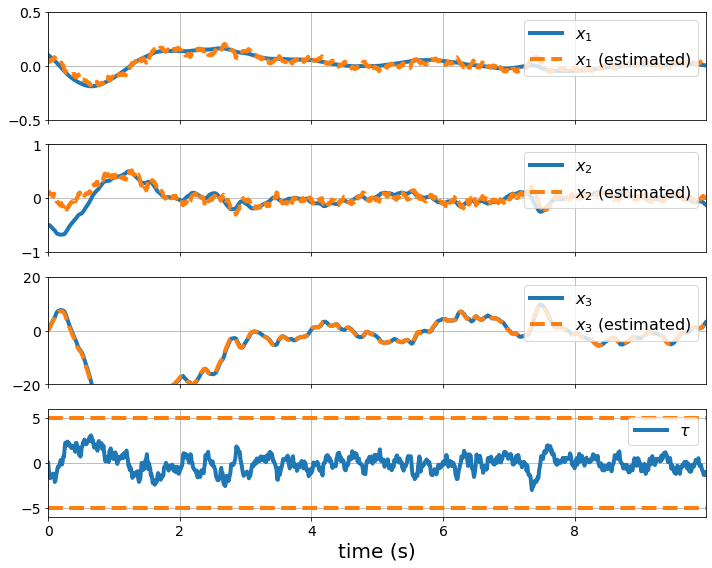

In [21]:
t = data['t']
q1 = data['platform_angle']
v1 = data['platform_velocity']
v2 = data['wheel_velocity']
tau = - data['wheel_torque']
q1_meas = data['platform_angle_measurement']
v2_meas = data['wheel_velocity_measurement']
x1 = q1 - q1e
x2 = v1 - v1e
x3 = v2 - v2e
xhat = data['xhat']

fig, (ax_x1, ax_x2, ax_x3, ax_tau) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
ax_x1.plot(t, xhat[:, 0], '--', label=r'$x_1$ (estimated)', linewidth=4)

ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
ax_x2.plot(t, xhat[:, 1], '--', label=r'$x_2$ (estimated)', linewidth=4)

ax_x3.plot(t, x3, label='$x_3$', linewidth=4)
ax_x3.plot(t, xhat[:, 2], '--', label=r'$x_3$ (estimated)', linewidth=4)

ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')

ax_x1.grid()
ax_x1.legend(fontsize=16, loc='upper right')
ax_x1.tick_params(labelsize=14)
ax_x1.set_ylim(-0.5, 0.5)

ax_x2.grid()
ax_x2.legend(fontsize=16, loc='upper right')
ax_x2.tick_params(labelsize=14)
ax_x2.set_ylim(-1, 1)

ax_x3.grid()
ax_x3.legend(fontsize=16, loc='upper right')
ax_x3.tick_params(labelsize=14)
ax_x3.set_ylim(-20, 20)

ax_tau.grid()
ax_tau.legend(fontsize=16, loc='upper right')
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

fig.tight_layout()
plt.show()